In [1]:
from PIL import Image
import numpy as np

## Посмотрим на входные изображения

In [2]:
image = Image.open("landscape_02.bmp") 
print(np.array(image).shape)

(359, 540, 4)


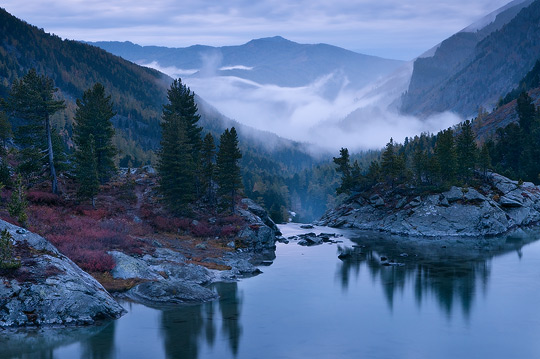

In [3]:
image

### Нам 4ый канал не нужен, уберём его

In [4]:
image = np.array(image)[:, :, :-1]
image.shape

(359, 540, 3)

In [5]:
import sys
import cv2 as cv
import numpy as np

MAX_KERNEL_LENGTH = 31

In [6]:
image = np.array(image)

In [7]:
dst = cv.medianBlur(image, 31)

In [8]:
Image.fromarray(np.array(dst))

In [9]:
def replicate_border(image, n):
    return cv.copyMakeBorder(image, n, n, n, n, cv.BORDER_REPLICATE)

In [10]:
Image.fromarray(replicate_border(image, 25))

In [11]:
image.shape

(359, 540, 3)

In [12]:
def simple_sort_median_blur(image: np.array, n: int) -> np.array: 
    """
    Применяет медианный фильтр к изображению
    В качестве алгоритма поиска медианы использует сортировку 
    
    Parameters
    ----------
    image: np.array
        входное изображение
    
    n: int
        радиус фильтра
    
    Returns
    -------
    np.array 
        изображение после применения медианного фильтра
    """
    res = np.zeros_like(image)
    image = replicate_border(image, n)
    median_pos = (2 * n + 1) ** 2 // 2
    
    for i in range(n, image.shape[0] - n):
        for j in range(n, image.shape[1] - n):
            # вариант с сортировкой (так как в задании написано сортировка, хотя можно использовать и np.median)
            res[i - n][j - n] = np.sort(image[i - n:i + n + 1, j - n:j + n + 1].reshape(-1, 3), axis=0)[median_pos]
            
            # вариант с медианой:
            # res[i - n][j - n] = np.median(image[i - n:i + n + 1, j - n:j + n + 1], axis=(0, 1))
    return res

In [13]:
res = simple_sort_median_blur(image, 15)

### Проверяем, что результат в точности совпадает с opencv

In [14]:
assert np.allclose(res, dst)

### Асимптотика алгоритма, использующего сортировку:
Размер изображения $M x N$, радиус окна $R$. Ещё есть число каналов (естественно, можно распараллелить по каналам), так как каналов 3, то в асимптотике не учитываем (и для остальных алгоритмов тоже).


Для каждого пикселя сортируем массив размера $(2R + 1)^2$, это требует 
$O(R^2logR)$ операций и $O(R^2)$ дополнительной памяти. Для нового пикселя не надо сохранять в памяти окно фильтра для предыдущего фильтра

В итоге $O(MNR^2logR)$ по числу операций и $O(R^2)$ по допольнительной памяти

In [15]:
from functools import partial


def huang_median_blur(image: np.array, n: int) -> np.array:
    """
    Применяет медианный фильтр к изображению
    В качестве алгоритма поиска медианы использует
    T. Huang, G. J. T. G. Y. Yang, and G. Tang, “A fast two-dimensional median filtering algorithm.” 1979
    
    Parameters
    ----------
    image: np.array
        входное изображение
    
    n: int
        радиус фильтра
    
    Returns
    -------
    np.array 
        изображение после применения медианного фильтра
    """
    image = replicate_border(image, n)
    channels = []
    for i in range(3):
        channels.append(huang_median_blur_for_channel(image[:, :, i], n))
    return np.concatenate(channels, -1)
    
    
def huang_median_blur_for_channel(image: np.array, n: int):
    median_pos = (2 * n + 1) ** 2 // 2
    res = np.zeros((image.shape[0] - 2 * n, image.shape[1] - 2 * n))
    
    for i in range(n, image.shape[0] - n):
        # инициализируем гистограмму
        hist = np.zeros(256)
        for b in image[i - n:i + n + 1, 0:2 * n + 1].reshape(-1):
            hist[b] += 1
        
        less_then_median = 0 
        median = 0
                
        while less_then_median + hist[median] <= median_pos:
            less_then_median += hist[median]
            median += 1
        
        res[i - n][0] = median         
        
        for j in range(n + 1, image.shape[1] - n):
            left = image[i - n:i + n + 1, j - n - 1]
            right = image[i - n:i + n + 1, j + n]
            
            # изменяем гистограмму, убирая левый столбец и 
            # добавляя правый
            for k in range(0, 2 * n + 1):
                b = left[k]
                hist[b] -= 1
                if b < median:
                    less_then_median -= 1
                
                b = right[k]
                hist[b] += 1
                
                if b < median:
                    less_then_median += 1
            
            
            if less_then_median > median_pos:
                while less_then_median > median_pos: 
                    median -= 1
                    less_then_median -= hist[median]
            else:
                while less_then_median + hist[median] <= median_pos:
                    less_then_median += hist[median]
                    median += 1
            
            res[i - n][j - n] = median
            
    return np.expand_dims(res, -1)

In [16]:
dst = cv.medianBlur(image, 31)

In [256]:
res = huang_median_blur(image, 15)

### Проверяем, что результат в точности совпадает с opencv

In [270]:
assert np.allclose(res, dst)

### Асимптотика алгоритма Huang et al:
Размер изображения $M x N$, радиус окна $R$, количество уровней квантования $L$ 

Для каждой строки считаем гистограмму по фильтру и находим её медиану за $O(R^2 + L)$ операций
При проходе вдоль строки для каждого столбца добавляем и убираем $O(R)$ пикселей из гистограммы и находим новую медиану за $O(L)$, при этом на каждом шаге храним гистограмму, это $O(L)$ дополнительной памяти (при текущей реализации колонки left и right фильтра тоже хранятся, это можно не делать)

В итоге получаем $O(MN(R + L))$ по числу операций и $O(L)$ по памяти

In [22]:
from functools import partial

def constant_time_blur(image: np.array, n: int) -> np.array:
    """
    Применяет медианный фильтр к изображению
    В качестве алгоритма поиска медианы использует
    S. Perreault, and H. Patrick, “Median filtering in constant time.” IEEE transactions on image processing, 2007
    
    Parameters
    ----------
    image: np.array
        входное изображение
    
    n: int
        радиус фильтра
    
    Returns
    -------
    np.array 
        изображение после применения медианного фильтра
    """
    image = replicate_border(image, n)
    channels = []
    for i in range(3):
        channels.append(constant_time_blur_for_channel(image[:, :, i], n))
    return np.concatenate(channels, -1)
    
    
def constant_time_blur_for_channel(image: np.array, n: int):
    median_pos = (2 * n + 1) ** 2 // 2
    res = np.zeros((image.shape[0] - 2 * n, image.shape[1] - 2 * n))
    
    def make_hist(arr):
        hist = np.zeros(256)
        for elem in arr:
            hist[elem] += 1
        return hist
   

    def find_median_in_hist(hist):
        less_then_median = 0 
        median = 0
        while less_then_median + hist[median] <= median_pos:
            less_then_median += hist[median]
            median += 1

        return median

    
    def shift_hist(arr):
        up = arr[0]
        down = arr[1]
        hist = arr[2:]
        hist[int(up)] -= 1
        hist[int(down)] += 1
        return hist
    

    hists = np.apply_along_axis(make_hist, 0, image[0:2 * n + 1, :]).T
    kernel_hist = np.sum(hists[:2 * n + 1], axis = 0) 
    
    # обрабатываем первую строчку
    res[0][0] = find_median_in_hist(kernel_hist)
        
    for j in range(n + 1, image.shape[1] - n):
        kernel_hist += hists[j + n]
        kernel_hist -= hists[j - n - 1]
        res[0][j - n] = find_median_in_hist(kernel_hist)
    
    # обрабатываем остальные строки
    for i in range(n + 1, image.shape[0] - n):
        # сдвигаем все гистограммы колонок на строчку ниже
        up = np.expand_dims(image[i - n - 1, :], -1)
        down = np.expand_dims(image[i + n], -1)
        hists = np.apply_along_axis(shift_hist, -1, np.concatenate((up, down, hists), -1))
        
        kernel_hist = np.sum(hists[:2 * n + 1], axis = 0)
        
        res[i - n][0] = find_median_in_hist(kernel_hist)
        
        for j in range(n + 1, image.shape[1] - n):
            kernel_hist += hists[j + n]
            kernel_hist -= hists[j - n - 1]
            res[i - n][j - n] = find_median_in_hist(kernel_hist)
            
    return np.expand_dims(res, -1)

In [26]:
dst = cv.medianBlur(image, 31)

In [27]:
res = constant_time_blur(image, 15)

### Проверяем, что результат в точности совпадает с opencv

In [28]:
assert np.allclose(res, dst)

### Асимптотика алгоритма constant_time O(1)

Размер изображения $M x N$, радиус окна $R$, количество уровней квантования $L$ 

Для первой строки подсчитываем гистограммы по столбцам размера $2R + 1$, это $O(NR)$ операций.
Для каждой строчки, кроме первой, сдвигаем все гистограммы колонок на строчку вниз, сдвиг одной гистограммы это $O(1)$ операций, суммарно $O(N)$
Для каждой строчки вычисляем гистограмму фильтра за $O(L^2)$ операций (складываем 2R + 1 столбец), потом, когда двигаемся по столбцам, добавляем и убираем по одной гистограмме колонки и вычисляем медиану по гистограмме, $O(L)$ операций, то есть суммарно $O(NL + L^2))$ операций. Считаем, что $L << N$.
Храним $O(NL)$ доп памяти на гистограммы.
 

В итоге $O(MNL)$ по числу операций и $O(NL)$ дополнительной памяти

In [48]:
sort_times = []
huang_times = []
constant_time_times = []

In [49]:
import time
from tqdm import tqdm

In [50]:
for n in tqdm([1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    print(f"Радиус фильтра {n}")
    start_time = time.time()
    res1 = simple_sort_median_blur(image, n)
    t = time.time() - start_time
    print(f"Время работы простой сортировки: {t} c")
    sort_times.append(t)
    
    start_time = time.time()
    res2 = huang_median_blur(image, n)
    t = time.time() - start_time
    print(f"Время работы алгоритма Huang et al.: {t} c")
    huang_times.append(t)
    
    start_time = time.time()
    res3 = constant_time_blur(image, n)
    t = time.time() - start_time
    print(f"Время работы алгоритма constant_time: {t} c")
    constant_time_times.append(t)
    
    start_time = time.time()
    dst = cv.medianBlur(image, 2*n + 1)
    t = time.time() - start_time
    print(f"Время работы алгоритма из OpenCV: {t} c")

    # дополнительная проверка, что для всех радиусов окна результаты в точности совпадают
    assert np.allclose(res1, dst)
    assert np.allclose(res2, dst)
    assert np.allclose(res3, dst)

  0%|                                                                                                                   | 0/12 [00:00<?, ?it/s]

Радиус фильтра 1
Время работы простой сортировки: 0.6115479469299316 c
Время работы алгоритма Huang et al.: 7.107696294784546 c


  8%|████████▉                                                                                                  | 1/12 [00:33<06:05, 33.26s/it]

Время работы алгоритма constant_time: 25.534548044204712 c
Время работы алгоритма из OpenCV: 0.00042128562927246094 c
Радиус фильтра 5
Время работы простой сортировки: 1.743131160736084 c
Время работы алгоритма Huang et al.: 21.611422300338745 c


 17%|█████████████████▊                                                                                         | 2/12 [01:22<07:06, 42.67s/it]

Время работы алгоритма constant_time: 25.878265142440796 c
Время работы алгоритма из OpenCV: 0.02059006690979004 c
Радиус фильтра 10
Время работы простой сортировки: 5.665653944015503 c
Время работы алгоритма Huang et al.: 40.559234857559204 c


 25%|██████████████████████████▊                                                                                | 3/12 [02:34<08:25, 56.19s/it]

Время работы алгоритма constant_time: 26.02398109436035 c
Время работы алгоритма из OpenCV: 0.01663994789123535 c
Радиус фильтра 20
Время работы простой сортировки: 21.258514165878296 c
Время работы алгоритма Huang et al.: 78.51249313354492 c


 33%|███████████████████████████████████▋                                                                       | 4/12 [04:40<11:08, 83.54s/it]

Время работы алгоритма constant_time: 25.68826985359192 c
Время работы алгоритма из OpenCV: 0.015299797058105469 c
Радиус фильтра 30
Время работы простой сортировки: 47.34641671180725 c
Время работы алгоритма Huang et al.: 116.91834497451782 c


 42%|████████████████████████████████████████████▏                                                             | 5/12 [07:50<14:14, 122.11s/it]

Время работы алгоритма constant_time: 26.203624963760376 c
Время работы алгоритма из OpenCV: 0.015403032302856445 c
Радиус фильтра 40
Время работы простой сортировки: 83.83951473236084 c
Время работы алгоритма Huang et al.: 154.93759989738464 c


 50%|█████████████████████████████████████████████████████                                                     | 6/12 [12:15<17:04, 170.69s/it]

Время работы алгоритма constant_time: 26.201632022857666 c
Время работы алгоритма из OpenCV: 0.014893770217895508 c
Радиус фильтра 50
Время работы простой сортировки: 130.04474401474 c
Время работы алгоритма Huang et al.: 194.06649112701416 c


 58%|█████████████████████████████████████████████████████████████▊                                            | 7/12 [18:06<19:07, 229.42s/it]

Время работы алгоритма constant_time: 26.192203044891357 c
Время работы алгоритма из OpenCV: 0.015442132949829102 c
Радиус фильтра 60
Время работы простой сортировки: 186.65180206298828 c
Время работы алгоритма Huang et al.: 233.32654213905334 c


 67%|██████████████████████████████████████████████████████████████████████▋                                   | 8/12 [25:32<19:53, 298.44s/it]

Время работы алгоритма constant_time: 26.21181011199951 c
Время работы алгоритма из OpenCV: 0.01565408706665039 c
Радиус фильтра 70
Время работы простой сортировки: 253.61451816558838 c
Время работы алгоритма Huang et al.: 273.5643208026886 c


 75%|███████████████████████████████████████████████████████████████████████████████▌                          | 9/12 [34:45<18:54, 378.16s/it]

Время работы алгоритма constant_time: 26.255903005599976 c
Время работы алгоритма из OpenCV: 0.01614093780517578 c
Радиус фильтра 80
Время работы простой сортировки: 334.7467978000641 c
Время работы алгоритма Huang et al.: 313.5446650981903 c


 83%|███████████████████████████████████████████████████████████████████████████████████████▌                 | 10/12 [46:00<15:39, 469.73s/it]

Время работы алгоритма constant_time: 26.46794295310974 c
Время работы алгоритма из OpenCV: 0.016833782196044922 c
Радиус фильтра 90
Время работы простой сортировки: 417.1394238471985 c
Время работы алгоритма Huang et al.: 351.74304699897766 c


 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 11/12 [59:15<09:29, 569.37s/it]

Время работы алгоритма constant_time: 26.383992195129395 c
Время работы алгоритма из OpenCV: 0.017325162887573242 c
Радиус фильтра 100
Время работы простой сортировки: 510.4601058959961 c
Время работы алгоритма Huang et al.: 392.38425302505493 c


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [1:14:44<00:00, 373.73s/it]

Время работы алгоритма constant_time: 26.039751052856445 c
Время работы алгоритма из OpenCV: 0.018140077590942383 c


In [51]:
sort_times = np.array(sort_times)
huang_times = np.array(huang_times)
constant_time_times = np.array(constant_time_times)

### 359 * 540 = 193860 пикселя, или 0.19386 мегапикселя

In [52]:
sort_times_scaled = sort_times / 0.19386
huang_times_scaled = huang_times / 0.19386
constant_time_times_scaled = constant_time_times / 0.19386

### ещё нужно перевести в миллисекунды

In [57]:
sort_times_scaled *= 1000
huang_times_scaled *= 1000
constant_time_times_scaled *= 1000

In [58]:
r = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

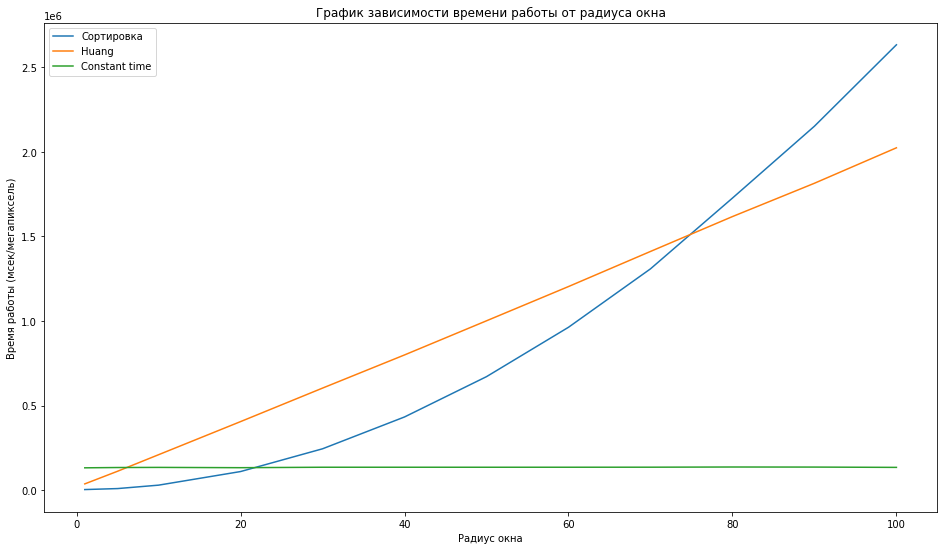

In [60]:
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 9))
plt.plot(r, sort_times_scaled, label = 'Сортировка')
plt.plot(r, huang_times_scaled, label = 'Huang')
plt.plot(r, constant_time_times_scaled, label = 'Constant time')
plt.title('График зависимости времени работы от радиуса окна')
plt.xlabel('Радиус окна')
plt.ylabel('Время работы (мсек/мегапиксель)')
plt.legend()
plt.show()

Из этого графика видно, что зависимость времени работы от радиуса окна для алгоритма, использующего сортировку, больше чем линейная и довольно сильно напоминает $\alpha R^2$ или $\alpha R^2logR$ (в данном случае логарифм практически не играет роли); для алгоритма Huang-а зависимость линейная, для алгоритма constant_time - константа, то есть фактическая асимптотика алгоритмов совпадает с теоретическими выводами  

### Параметры для композиции алгоритмов: при $R \le 21$ используем простую сортировку, при $R > 21$ используем constant_time

### Сохраним результаты работы алгоритмов 

In [61]:
n = 15
res1 = simple_sort_median_blur(image, n)
res2 = huang_median_blur(image, n)
res3 = constant_time_blur(image, n)
dst = cv.medianBlur(image, 2 * n + 1)

In [62]:
Image.fromarray(np.array(res1, dtype=np.uint8)).save('simple_sort_result.bmp')
Image.fromarray(np.array(res2, dtype=np.uint8)).save('huang_result.bmp')
Image.fromarray(np.array(res3, dtype=np.uint8)).save('constant_time_result.bmp')
Image.fromarray(np.array(dst, dtype=np.uint8)).save('opencv_result.bmp')

### Протестируем ещё на одном изображении

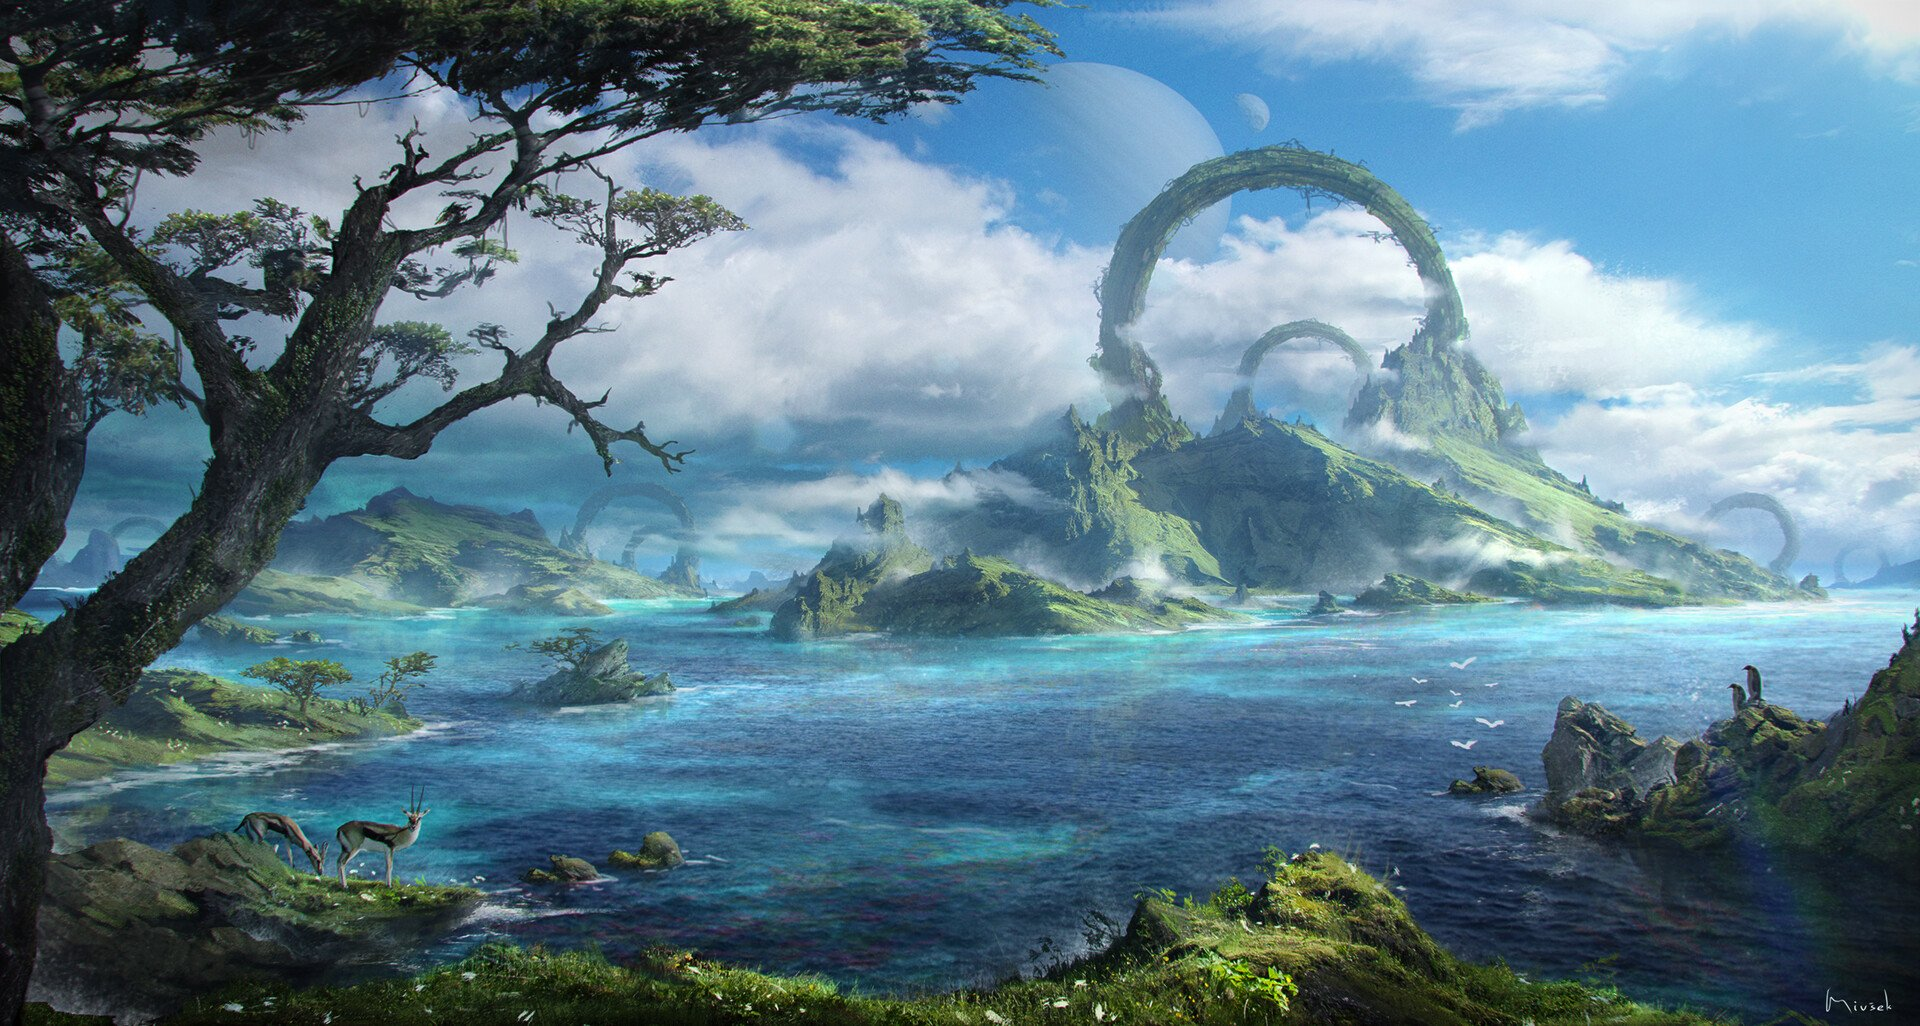

In [68]:
image = Image.open("landscape_01.bmp") 
image

In [69]:
image = np.array(image)[:, :, :-1]
image.shape

(1026, 1920, 3)

In [70]:
n = 14
res1 = simple_sort_median_blur(image, n)
res2 = huang_median_blur(image, n)
res3 = constant_time_blur(image, n)
dst = cv.medianBlur(image, 2 * n + 1)

assert np.allclose(res1, dst)
assert np.allclose(res2, dst)
assert np.allclose(res3, dst)